In [1]:
from importlib import reload
import audioDatastore.AudioDatastore as myads
reload(myads)
import os.path
from collections import Counter
import random
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from spafe.utils import vis
import matplotlib.pyplot as plt
import misc.vad as vad
from sklearn.mixture import GaussianMixture, _gaussian_mixture
reload(vad)
import numpy as np
from scipy.special import logsumexp


In [2]:
# helper functions

# [2] feature extraction
# 	• Normalize the audio
# 	• Use detectSpeech to remove nonspeech regions from the audio
# 	• Extract features from the audio
# 	• Normalize the features
#   * Apply cepstral mean normalization

eps = np.finfo(np.float64).eps

def helper_feature_extraction(raw_audio_file, norm = None):
    # read in file
    (signal_rate, signal) = wav.read(raw_audio_file)

    # normalise
    signal = signal / max(signal)

    # detect speech => convert this into one function
    v = vad.VoiceActivityDetector(signal_rate, signal, 0.5)
    detected_speach = v.detect_speech()
    idx = v.convert_windows_to_readible_labels(detected_speach)
    if idx:
        signal = signal[idx[0]:idx[1]]
        mfcc_feats = mfcc(signal=signal, samplerate=signal_rate, ceplifter=0, preemph=0, numcep=13, appendEnergy=False)

        # feature normalisation and Cepstral mean subtraction (for channel noise)
        if norm:
            mfcc_feats = (mfcc_feats - norm.means) / norm.std
            mfcc_feats = mfcc_feats - np.mean(mfcc_feats)
            return mfcc_feats
        else:
            return mfcc_feats
    else:
        return []

In [3]:
# [1] separate data into train, enroll and verify

datasetFolder = r"C:\Users\David\OneDrive\Desktop\matlab\data\speech_commands_v0.01"
main_ads = myads.AudioDatastore()
main_ads.populate(datasetFolder,include_sub_folders=True, label_source=True)

In [4]:
ads = myads.subset(main_ads, label='stop')

speakers = []
for file in ads.files:
    nm = os.path.basename(file)
    nm = nm.split('_')[0]
    speakers.append('a' + nm)

ads.set(labels=speakers)

In [5]:
num_speakers_to_enroll = 10
label_count = Counter(ads.labels)
for_enroll_and_test_set = []
for key, cnts in list(label_count.items()):
    if cnts >= 3:
        for_enroll_and_test_set.append(key)
for_enroll = for_enroll_and_test_set[0:num_speakers_to_enroll]
ads_enroll_and_validate = myads.subset(ads, label=for_enroll)
ads_enroll, _ = myads.split(ads_enroll_and_validate, 2)

ads_test = myads.subset(ads, for_enroll_and_test_set)
ads_test = myads.filter(ads_test, ads_enroll.files) # by file

ads_train_ubm = myads.filter(ads, ads_test.files)
ads_train_ubm = myads.filter(ads_train_ubm, ads_enroll.files)

In [6]:
import pickle

reload = False

try:
    if reload :
        raise Exception('reloading')
    all_features = pickle.load(open('all_features.pickle','rb'))
except:
    all_features = []
    for file in ads.files:
        feature = helper_feature_extraction(file)
        all_features.append(feature)
    pickle.dump(all_features, open('all_features.pickle','wb'))


In [7]:
# collect normalization factors

import numpy as np
# means = np.mean(all_features.fl, axis=0)
means = []
std = []
for feature in all_features:
    if len(feature) > 0:
        means.append(np.mean(feature, axis=0))
        std.append(np.std(feature, axis=0))

means = np.array(means)
means = np.mean(means, axis=0)

std = np.array(std)
std = np.mean(std, axis=0)

class NormFactor:
  def __init__(self, m, s):
    self.means = m
    self.std = s

normFactors = NormFactor(means, std)

print(normFactors.means)

try:
    if reload :
        raise Exception('reloading')
    normFactors = pickle.load(open('normFactors.pickle','rb'))
except:
    pickle.dump(normFactors, open('normFactors.pickle','wb'))

# mean:, -36.9458, 3.1896, 0.0495, -0.5411, -0.6870, 0.2553, 0.1708, 0.0510, -0.2031, 0.0724, -0.1137, -0.1732, -0.2848
# STD: ?
# var: 3.9802, 3.4728, 1.9646, 1.3817, 1.1938, 0.8688, 0.8556, 0.7081, 0.6282, 0.538, 0.531, 0.5688, 0.5188


[-31.59474313   8.10455255  -2.55111036  -1.90398935  -2.05609326
   0.28186454   0.44159752  -0.11896976  -0.65464011  -0.03424841
  -0.45836605  -0.54274028  -0.79374816]


In [8]:
# normalise features

normalised_features = []

# save normalised features

try:
    normalised_features = pickle.load(open('normalised_features.pickle','rb'))
    if reload:
        raise Exception('reloading')
except:
    for i in range(len(all_features)):
        if len(all_features[i]) > 0:
            normalised = (all_features[i] - means) / std
            normalised = normalised - np.mean(normalised)
            normalised_features.append(normalised)
        else:
            normalised_features.append(np.array([]))
    pickle.dump(normalised_features, open('normalised_features.pickle','wb'))


In [10]:
# [3] gmm ubm EM, skip

# 3.a collect train features
maxFeatures = len(ads_train_ubm.files) # len(
train_features = []
for f in range(maxFeatures):
    # extract a feature
    train_feature = helper_feature_extraction(ads_train_ubm.files[f], normFactors)
    if len(train_feature) == 0:
        print('zero length feature at index: ' + str(f))
    else:
        train_features.append(train_feature)

zero length feature at index: 5
zero length feature at index: 23
zero length feature at index: 45
zero length feature at index: 138
zero length feature at index: 148
zero length feature at index: 165
zero length feature at index: 238
zero length feature at index: 239
zero length feature at index: 250
zero length feature at index: 281
zero length feature at index: 282
zero length feature at index: 295
zero length feature at index: 306
zero length feature at index: 307
zero length feature at index: 322
zero length feature at index: 333
zero length feature at index: 363
zero length feature at index: 364
zero length feature at index: 369
zero length feature at index: 382
zero length feature at index: 399
zero length feature at index: 405
zero length feature at index: 409
zero length feature at index: 451
zero length feature at index: 455
zero length feature at index: 462
zero length feature at index: 528
zero length feature at index: 553
zero length feature at index: 570
zero length featur

KeyboardInterrupt: 

In [21]:
# 3.b create UBM using sklearn, skip

from sklearn.mixture import GaussianMixture, _base, _gaussian_mixture

numComponents = 32
alpha = np.ones(numComponents) / numComponents
numFeatures = normalised_features[0].shape[1]
mu = np.random.random((numComponents,numFeatures))
sigma = np.random.random((numComponents,numFeatures))

# TODO function to init GMM
ubm = GaussianMixture(n_components=numComponents, covariance_type='diag', weights_init=alpha, means_init=mu, precisions_init=sigma)

ubm.means_ = mu
ubm.covariances_ = sigma
ubm.weights_ = alpha
ubm.precisions_cholesky_ = _gaussian_mixture._compute_precision_cholesky(sigma, 'diag')

In [22]:
# 3.c em algorithm # skip

maxIter = 100
targetLogLikelihood = 0
tol = 1e-3
pastL = -np.inf

for i in range(maxIter):

    # E step
    N = np.zeros((1, numComponents))
    F = np.zeros((numFeatures, numComponents))
    S = np.zeros((numFeatures, numComponents))
    L = 0


    for feature in train_features:
        # check for sub par samples
        if len(feature) > 0:
            logLikelihood = ubm._estimate_weighted_log_prob(feature)
            logLikelihoodSum = logsumexp(logLikelihood, axis=1)
            gamma = np.exp((logLikelihood.T - logLikelihoodSum)).T

            # Compute Baum-Welch stats
            n = np.sum(gamma,axis=0)
            f = np.dot(feature.T, gamma)
            s = np.dot(feature.T * feature.T, gamma)

            N = N + n
            F = F + f
            S = S + s

            L = L + np.sum(logLikelihoodSum)

    # M step
    L = L / len(train_features)
    if i%10 == 0:
        print('iter: ' + str(i) + ', log likelihood ' + str(L))
    if L > targetLogLikelihood or np.abs(pastL - L) < tol:
        print('converged on iter: ' + str(i))
        ubm.converged_ = True
        break
    else:
        pastL = L

    # TODO create function out of this
    N = np.maximum(N, eps)
    weights = np.maximum(N / np.sum(N), eps)
    newWeights = weights / np.sum(weights)  # why again, because of eps ...
    newMeans = F / N
    newCovariances = np.maximum((S / N) - np.square(ubm.means_).T, eps)
    ubm.weights_ = np.squeeze(newWeights.T)
    ubm.means_ = newMeans.T
    ubm.covariances_ = newCovariances.T


iter: 0, log likelihood -6664.798061316596
iter: 10, log likelihood -5278.89807991309
iter: 20, log likelihood -5226.25744729094
iter: 30, log likelihood -5205.135872586785
iter: 40, log likelihood -5193.571263263209
iter: 50, log likelihood -5185.511126132337
iter: 60, log likelihood -5181.354714833754
iter: 70, log likelihood -5177.664894153763
iter: 80, log likelihood -5173.590992279247
iter: 90, log likelihood -5170.6458312371715


In [8]:
# sklearn does better - probably because of k means init

ubm_test = GaussianMixture(n_components=32, covariance_type='diag')
train_features_flattened = np.array([item for sublist in train_features for item in sublist])
ubm_test.fit(train_features_flattened)
print('sklearn model' + str(ubm_test.score(train_features[0])))
# print('my model' + str(ubm.score(train_features[0])))

NameError: name 'train_features' is not defined

In [14]:
# saving sklearns version for the moment
# pickle.dump(ubm_test, open('ubm.pickle','wb'))

In [9]:
# save model

try:
    ubm = pickle.load(open('ubm.pickle','rb'))
except:
    pickle.dump(ubm, open('ubm.pickle','wb'))


In [10]:
# [4] map enroll
import helper_functions as hf
# reload(hf)

# do stuff
numComponents = 32
numFeatures = 13
relevanceFactor = 16
speakers = np.unique(ads_enroll.labels)
numSpeakers = len(speakers)
gmmCellArray = []

for i in range(len(speakers)):
    adsTrainSubset = myads.subset(ads_enroll, speakers[i])
    N = np.zeros((1, numComponents))
    F = np.zeros((numFeatures, numComponents))
    S = np.zeros((numFeatures, numComponents))

    for file in adsTrainSubset.files:
        speaker_feature = helper_feature_extraction(file, normFactors)
        if len(speaker_feature) > 0:
            # BW stats, # TODO make this in to function
            n,f,s,l = hf.helper_expectation(speaker_feature, ubm)
            N = N + n
            F = F + f
            S = S + s
        else:
            print('skipping train file because len = 0')

    gmm = hf.helper_maximization(N,F,S,numComponents)

    alpha = N / (N + relevanceFactor)

    mu = (alpha.T*gmm.means_) + ((1-alpha).T*ubm.means_)
    gmm.means_ = mu

    sigma = alpha*(S/N) + (1-alpha)*(ubm.covariances_.T + np.square(ubm.means_).T) - np.square(gmm.means_).T
    sigma = np.maximum(sigma, eps).T
    gmm.covariances_ = sigma

    gmm.precisions_cholesky_ = _gaussian_mixture._compute_precision_cholesky(gmm.covariances_, 'diag')

    weights = alpha*(N/np.sum(N)) + (1-alpha)*ubm.weights_.T
    weights = np.squeeze(weights/np.sum(weights))
    gmm.weights_ = weights

    gmmCellArray.append(gmm)

print('speaker enrollment complete')

speaker enrollment complete


In [11]:
# quick test
adsTrainSubset = myads.subset(ads_enroll, speakers[0])
speaker_feature = helper_feature_extraction(adsTrainSubset.files[1], normFactors)
adapted_score = gmmCellArray[0].score(speaker_feature)
ubm_score = ubm.score(speaker_feature)
print(adapted_score, ubm_score)

-21.733449314206496 -25.29854786690323


In [12]:
enrolled_gmms = {}
for i in range(len(gmmCellArray)):
    enrolled_gmms[speakers[i]] = gmmCellArray[i]

In [13]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [14]:
# false rejection rate -
# The speaker false rejection rate (FRR) is the rate that a given speaker is incorrectly rejected. Use the known speaker set to determine the speaker false rejection rate for a set of thresholds.

llr = []

for i in range(len(speakers)):
    cur_speaker = speakers[i]
    local_gmm = enrolled_gmms[cur_speaker]
    adsTestSubset = myads.subset(ads_test, cur_speaker)
    llrPerSpeaker = np.zeros(len(adsTestSubset.files))

    for y in range(len(adsTestSubset.files)):
        file = adsTestSubset.files[y]
        speaker_feature = helper_feature_extraction(file, normFactors)

        if len(speaker_feature) > 0:

            logLikelihood = local_gmm._estimate_weighted_log_prob(speaker_feature)
            lspeaker = logsumexp(logLikelihood, axis=1)

            logLikelihood = ubm._estimate_weighted_log_prob(speaker_feature)
            lubm = logsumexp(logLikelihood, axis=1)

            llrPerSpeaker[y] = np.mean(running_mean(lspeaker-lubm, 3))

    llr.append(llrPerSpeaker)


In [17]:
llr_cat = np.concatenate(llr, axis=0)
thresholds = np.arange(-0.5,2.5,0.01)
thresholds = np.expand_dims(thresholds, axis=1)
ones = np.ones((1, len(llr_cat)))
thresholds = thresholds * ones
frr = np.mean((llr_cat < thresholds), axis=1)

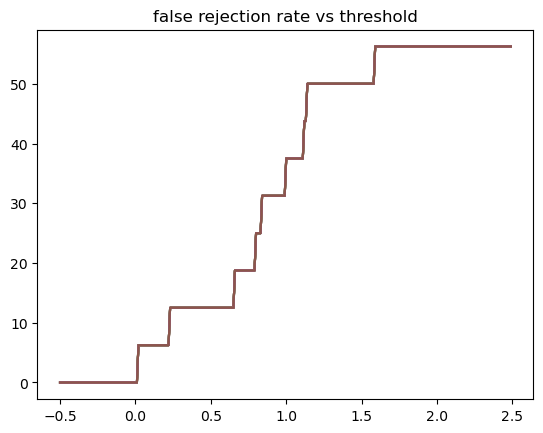

In [18]:
import matplotlib.pyplot as plt

plt.plot(thresholds, frr * 100)
plt.title('false rejection rate vs threshold')
plt.show()

In [21]:
## Speaker False Acceptance

llr = []

for i in range(len(speakers)):
    cur_speaker = speakers[i]
    local_gmm = enrolled_gmms[cur_speaker]
    filtered = speakers[i] != speakers
    filtered_speakers = speakers[filtered]
    adsTestSubset = myads.subset(ads_test, filtered_speakers)
    llrPerSpeaker = np.zeros(len(adsTestSubset.files))

    for y in range(len(adsTestSubset.files)):
        file = adsTestSubset.files[y]
        speaker_feature = helper_feature_extraction(file, normFactors)

        if len(speaker_feature) > 0:

            logLikelihood = local_gmm._estimate_weighted_log_prob(speaker_feature)
            lspeaker = logsumexp(logLikelihood, axis=1)

            logLikelihood = ubm._estimate_weighted_log_prob(speaker_feature)
            lubm = logsumexp(logLikelihood, axis=1)

            llrPerSpeaker[y] = np.mean(running_mean(lspeaker-lubm, 3))

        else:
            print('zero feature length')

    llr.append(llrPerSpeaker)

print('far computed')

far computed


In [22]:
llr_cat = np.concatenate(llr, axis=0)
thresholds = np.arange(-0.5,2.5,0.01)
thresholds = np.expand_dims(thresholds, axis=1)
ones = np.ones((1, len(llr_cat)))
thresholds = thresholds * ones
far = np.mean((llr_cat > thresholds), axis=1)

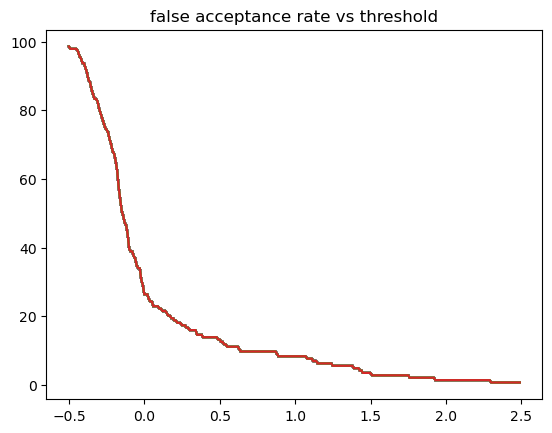

In [23]:
plt.plot(thresholds, far * 100)
plt.title('false acceptance rate vs threshold')
plt.show()

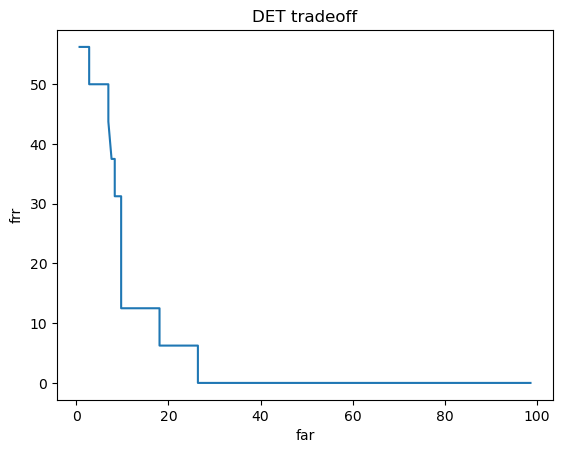

In [24]:
# plot de
x1 = far * 100
y1 = frr * 100
plt.plot(x1,y1)
plt.title('DET tradeoff')
plt.xlabel('far')
plt.ylabel('frr')
plt.show()

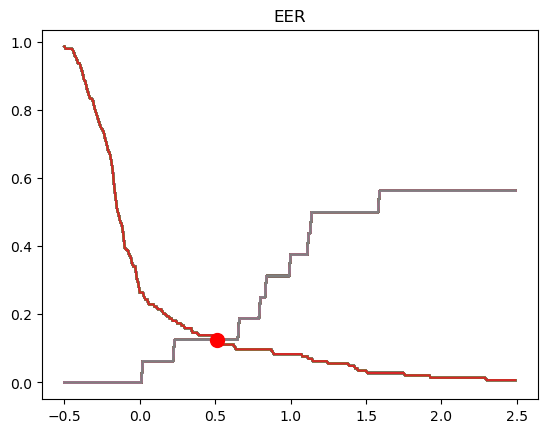

In [36]:
# Equal Error tradeoff
# the threshold where FRR and FAR meet is useful as a metric when comparing systems

diff = (np.abs(far - frr))
idx = np.argmin(diff)
EERThreshold = thresholds[idx]
EER = np.mean([far[idx], frr[idx]])

plt.plot(thresholds, far)
plt.plot(thresholds, frr)
plt.plot(EERThreshold[0], EER, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.title('EER')
plt.show()

0.125